In [1]:
import pandas as pd
import os, io
import yaml
import numpy as np
import requests
import gmaps
import tqdm

from selenium import webdriver
from ipywidgets.embed import embed_minimal_html

## DB TO TEST

In [2]:
import httplib2
import io
import argparse


from httplib2 import Http
from oauth2client import file,client, tools
from googleapiclient import discovery
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client.service_account import ServiceAccountCredentials

SCOPES = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive.file',
         'https://www.googleapis.com/auth/spreadsheets.currentonly',
         'https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/presentations',
         'https://www.googleapis.com/auth/drive.scripts',
         'https://www.googleapis.com/auth/drive.appdata',
         'https://www.googleapis.com/auth/drive.metadata'
        ]
store = file.Storage('/Users/daniel/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/daniel/OAN/credentials/storage.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))
sheet_service = discovery.build('sheets', 'v4', http=creds.authorize(Http()))

In [3]:
cred_map='/Users/daniel/OAN/credentials/maps.yaml'

In [4]:
cred_map_yaml=yaml.load( open(cred_map, "r" ),Loader=yaml.FullLoader)

In [5]:
ID=cred_map_yaml['SHEET_ID']

In [7]:
RANGE_NAME = 'ARCGIS'
    
gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=ID, range=RANGE_NAME).execute()

df_villages=pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

## FUNCTIONS

In [8]:

Point = namedtuple('Point', 'x y')

def points_adjoin(p1, p2):
    # to accept diagonal adjacency, use this form
    #return -1 <= p1.x-p2.x <= 1 and -1 <= p1.y-p2.y <= 1
    return (-1 <= p1.x-p2.x <= 1 and p1.y == p2.y or
             p1.x == p2.x and -1 <= p1.y-p2.y <= 1)

def adjoins(pts, pt):
    return any(points_adjoin(p,pt) for p in pts)

def locate_regions(datastring):
    data = datastring
    regions = []
    datapts = [Point(x,y) 
                for y in range(len(data[0]))
                    for x in range(len(data)) if data[x][y]==1]
    for dp in datapts:
        # find all adjoining regions
        adjregs = [r for r in regions if adjoins(r,dp)]
        if adjregs:
            adjregs[0].add(dp)
            if len(adjregs) > 1:
                # joining more than one reg, merge
                regions[:] = [r for r in regions if r not in adjregs]
                regions.append(reduce(set.union, adjregs))
        else:
            # not adjoining any, start a new region
            regions.append(set([dp]))
    return regions

def region_index(regs, p):
    return next((i for i,reg in enumerate(regs) if p in reg), -1)

def print_regions(regs):
    maxx = max(p.x for r in regs for p in r)
    maxy = max(p.y for r in regs for p in r)
    allregionpts = reduce(set.union, regs)
    line = np.ones((maxx+4,maxy+3)) #  empty regular list
    
    for y in range(-1,maxy+2):
        
        for x in range(-1,maxx+2):
            p = Point(x, y)
            if p in allregionpts:
                line[x][y]=1
            else:
                line[x][y]=0


    return line
# test against data set

def get_coord(m_x,m_y,center,im):
     #Lat = Y Long = X
    
    #got manually
    range_x_long=abs(9.96243-9.95707)
    range_y_lat=abs(2.94223 - 2.95123)
    
    
    y_size=len(im[0])
    x_size=len(im)
    
    
    lat_y=center[0] + range_x_long/2 - m_y*range_x_long/x_size
    long_x=center[1] - range_y_lat/2 + m_x*range_y_lat/y_size
    
    return (lat_y,long_x)

NameError: name 'namedtuple' is not defined

In [9]:
def read_image(image):
    kk = imread(image,-1)
    #plt.figure()
    #plt.imshow(kk)
    return kk
def read_image_gray(image):
    bgr_img = imread(image,0) #cv2.IMREAD_GRAYSCALE
    #plt.figure()
    #plt.imshow(bgr_img)
    return bgr_img
def segmentation_by_color(image,th):
    ret,im_thresh= cv2.threshold(image,th,255,cv2.THRESH_BINARY_INV)
    #print (init)
    '''
    alpha Higher values make snake contract faster
    beta Highervalue make snake smoother
    Gamma Timestepping parameter
    '''
    #plt.figure()
    #plt.imshow(im_thresh)
    return im_thresh
#smooth and threshold as image has compression artifacts (jpg)
def gaus_filter(image,sigma):
    im = ndimage.gaussian_filter(image/2, sigma)
    im[im<10]=0
    im[im>=10]=255
    blobs, number_of_blobs = ndimage.label(im)

    #plt.figure()
    #plt.imshow(blobs)
    
    return blobs
def polarisation(blobs):
    a=blobs/255

    a=np.where(a==0, 2, a)
    a=np.where(a!=2, 0, a)
    a=np.where(a==2, 1, a)
    
        
    #plt.figure()
    #plt.imshow(a)
    
    return a
def region_detection(a):
    regs = locate_regions(a)

    #line = print_regions(regs)

    #plt.figure(figsize = (20,10))
    #plt.imshow(line)

    print("Number of HOUSES FOUND : % 3d"%(len(regs)))
    return regs

def count_regions_and_plot_and_getcoord(regs,size,begin,im,center):  
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.imshow(im)
    size_thr=size
    j=0
    coord=[]
    for reg,x_beg in zip(regs,begin):
        if len(reg)>0:
            for i,r in enumerate(reg):
                size_reg = len(r)
                if size_reg > size_thr:
            
                    pixels_x = [p.y for p in r]
                    pixels_y = [p.x+x_beg  for p in r]
            
                    m_x = np.mean(pixels_x)
                    m_y = np.mean(pixels_y)
                    
                    
                    coord.append(get_coord(m_x,m_y,center,im))
                    #print(i,m_x,m_y)
            
                    r = max([(max(pixels_x)-min(pixels_x)),(max(pixels_y)-min(pixels_y)),10])
            
                    s = np.linspace(0, 2*np.pi, int(r/2))
            
                    c = m_x + 3*np.cos(s)
                    d = m_y + 3*np.sin(s)
                    init = np.array([c, d]).T
                    #snake = active_contour(kk, init)
            
                    ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
                    #ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
            
                    # ax.set_xticks([]), ax.set_yticks([])
                    #ax.axis([0, bgr_img.shape[1], bgr_img.shape[0], 0])
            
                    j += 1
            
    d = len(im)/2 + 1*np.cos(s)
    c = len(im[0])/2 + 1*np.sin(s)
    init = np.array([c, d]).T   
    #ax.plot(init[:, 0], init[:, 1], '--b', lw=3)
    print("Number of HOUSES FOUND WITH SIZE FILTER %1d pixels: % 3d"%(size_thr,j))
    plt.show() 
    return coord

## OPEN FIRST VILLAGE

In [10]:
num=5

In [11]:
village=df_villages.loc[num,'Translate']
village

'DJONWOURA KPAROU'

In [12]:
overpass_url = "http://overpass-api.de/api/interpreter"

#When the village is well defined
overpass_query = ("""
[out:json];
area['name'='"""+village+
"""']->.a;
way[building](area.a);
(._;>;);
out body;
""")

#When the village is a dot or something
overpass_query_2 = ("""
[out:json];
way['name'='"""+village+
"""'];
way(around:1000)[building];
(._;>;);
out body;
""")

#get Data
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
#response_2 = requests.get(overpass_url, 
#                        params={'data': overpass_query_2})
data = response.json()
#data = response_2.json()

In [13]:
houses = []
ways=[elem for elem in data['elements']  if elem['type']=='way']
nodes=[elem for elem in data['elements']  if elem['type']=='node']
for way in ways:
    houses_info={}
    houses_info['id']=way['id']
    nodes_lats=[]
    nodes_longs=[]
    houses_info['nodes']=way['nodes']
    for node in nodes:
        if node['id'] in houses_info['nodes']:
            nodes_lats.append(node['lat'])
            nodes_longs.append(node['lon'])
    houses_info['lat']=np.mean(np.array(nodes_lats))
    houses_info['lon']=np.mean(np.array(nodes_longs))
    houses.append(houses_info)

In [14]:
df_houses=pd.DataFrame(houses)

In [15]:
len(df_houses)

6

In [16]:
df_houses.head(4)

,id,nodes,lat,lon
0,740485287,"[6932730623, 6932730624, 6932730625, 693273062...",9.887464,3.403040
1,740485288,"[6932730627, 6932730628, 6932730629, 693273063...",9.887354,3.402945
2,740485289,"[6932730631, 6932730632, 6932730633, 693273063...",9.887228,3.403026
3,740485290,"[6932730635, 6932730636, 6932730637, 693273063...",9.887253,3.402943


In [17]:
#Mapbox
#center=(df_houses.lon.mean(),df_houses.lat.mean())
#googleMaps
center=(df_houses.lat.mean(),df_houses.lon.mean())

## open data in GMAPS

In [23]:
os.environ["GOOGLE_API_KEY"]=cred_map_yaml["GOOGLE_API_KEY"]

In [24]:
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [25]:
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px'
}
zoom_level=17

In [26]:
fig2 = gmaps.figure(center=center,
                   zoom_level=zoom_level,
                   map_type='SATELLITE',
                   layout=figure_layout)

In [27]:
fig2

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px', width='800px'))

In [732]:
house_points=[a for a in df_houses.apply(lambda x: (x.lat,x.lon),axis=1)]

In [733]:
#marker_layer = gmaps.marker_layer(house_points)

In [746]:
marker_layer=gmaps.symbol_layer(
    house_points, fill_color='red', stroke_color='black', scale=2
)

In [744]:
fig2.add_layer(marker_layer)

In [745]:
fig2

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px', width='800px'))

# EXPORT MAP

# HTML

In [681]:
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px'
}

In [682]:
fig = gmaps.figure(center=center,
                   zoom_level=zoom_level,
                   map_type='SATELLITE',
                   layout=figure_layout)
embed_minimal_html('gmap.html', views=[fig])

# Upload the image

In [34]:
driver = webdriver.Chrome(executable_path=
                          r'/Users/daniel/OAN/nikki_map_house_count/maps_scrapping/chromedriver')

In [683]:
file = "file:/Users/daniel/OAN/nikki_map_house_count/all_tog/gmap.html"

In [684]:
driver.get(file)

In [702]:
driver.find_elements_by_class_name("gmaps-toolbar-btn")[0].click()

In [641]:
source="/Users/daniel/Downloads/map.png"

In [703]:
#end="/Users/daniel/OAN/nikki_map_house_count/all_tog/"+village+'.png'
end="/Users/daniel/OAN/nikki_map_house_count/all_tog/try_nohouses.png"

In [704]:
os.rename(source, end)

## CUT IMAGE

In [42]:
from PIL import Image

In [43]:
def crop(image_path, coords, saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)

In [705]:
#cut="/Users/daniel/OAN/nikki_map_house_count/all_tog/"+village+'2.png'
cut="/Users/daniel/OAN/nikki_map_house_count/all_tog/try_nohouses2.png"

In [706]:
crop(end,(0, 100, 745, 535),cut)

# IMPORTS

In [48]:
import firebase_admin
import numpy as np
import matplotlib.pyplot as plt

In [54]:
import cv2
import skimage
import scipy
import imageio

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from cv2 import imread
from cv2 import imwrite


from skimage.morphology import opening, disk, closing
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage


from sklearn.cluster import KMeans

from PIL import Image, ImageDraw, ImageFont

from functools import reduce

from collections import namedtuple


from firebase_admin import credentials
from firebase_admin import firestore

# CONNECT TO FIREBASE

In [57]:
filename='/Users/daniel/OAN/credentials/firebase_parameters.json'

In [58]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

## params

In [695]:
size=800
lat=center[0]
long=center[1]
lat_long=center
lat_screen=float(lat_long[1])
long_screen=float(lat_long[0])

# COUNT HOUSES

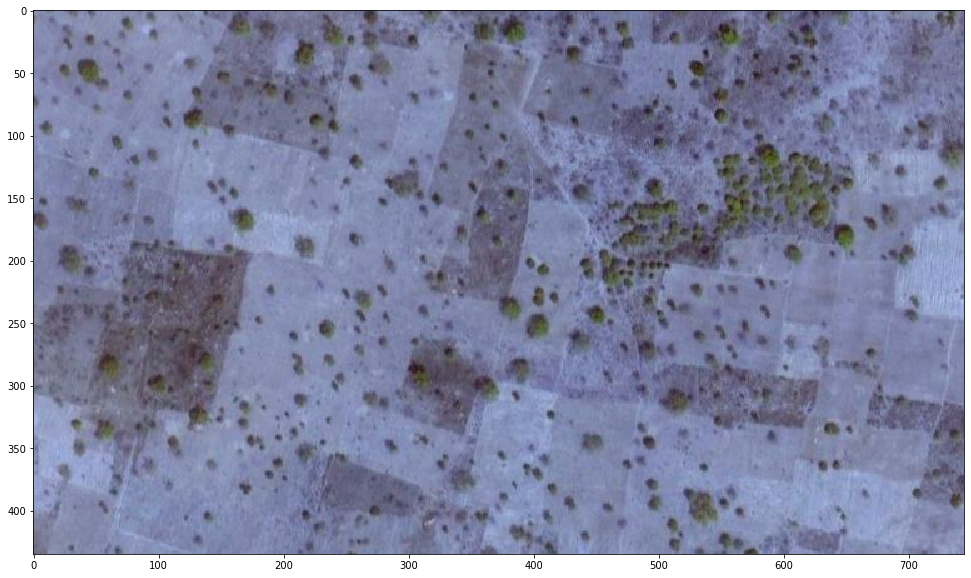

In [707]:
#image =village+'2.png'
image='try_nohouses2.png'

im=read_image(image)

plt.figure(figsize=(20,10))
plt.imshow(im)

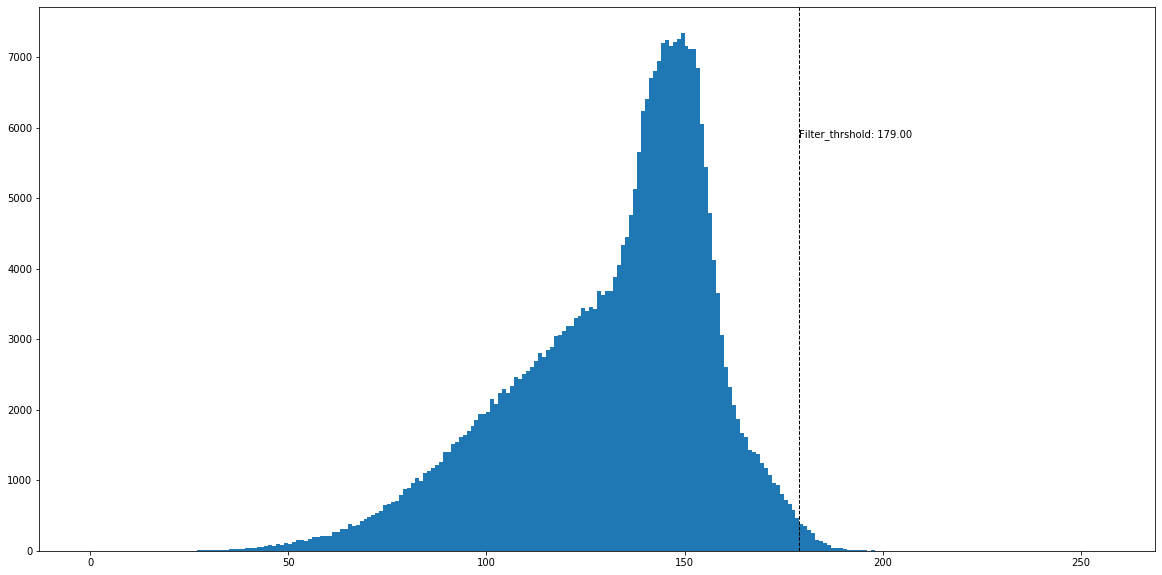

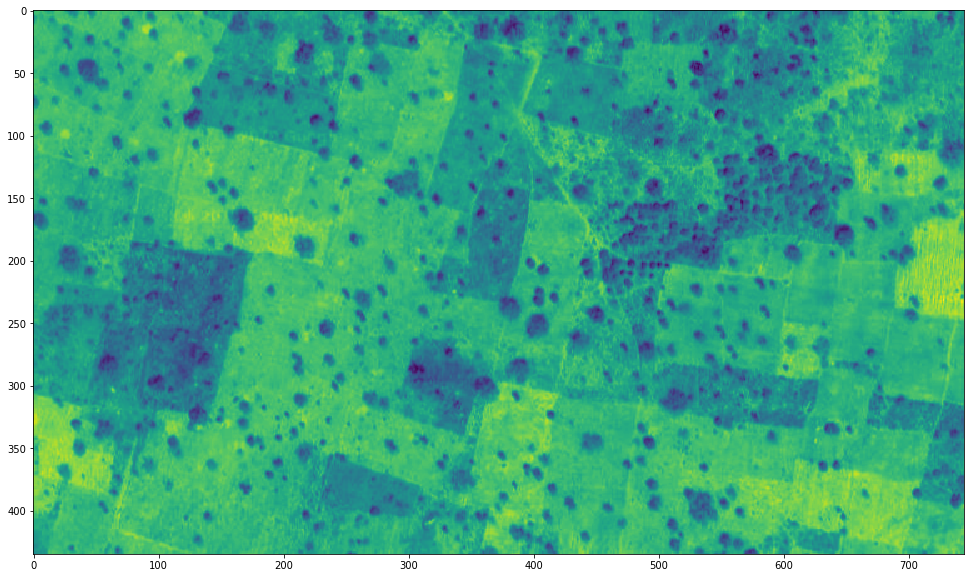

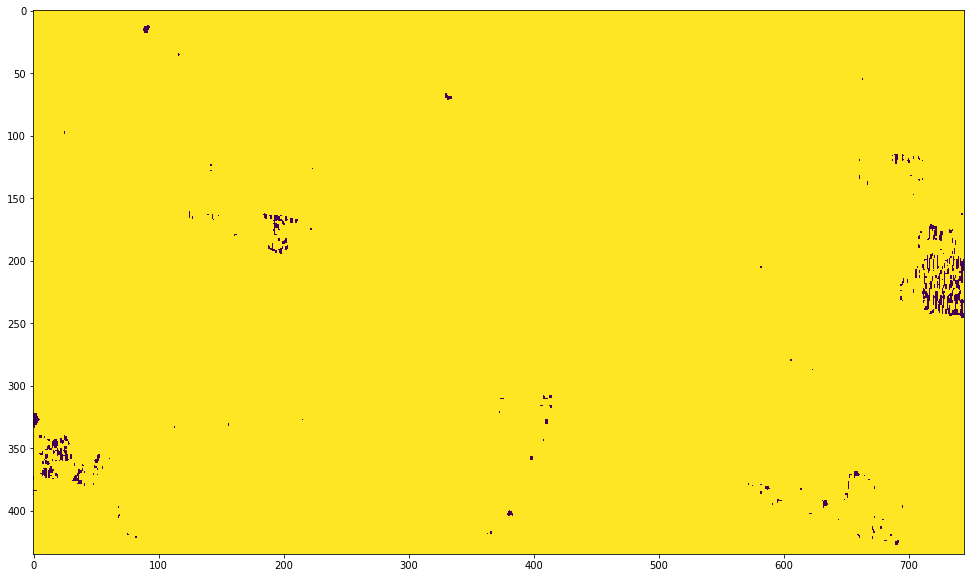

In [708]:
gr_image = read_image_gray(image)

pixels=gr_image.ravel()

f,ax = plt.subplots(figsize=(20,10))

n, b, patches =ax.hist(pixels,256,[0,256])

quantile=0.994

filter_thrs = np.quantile(pixels,quantile)

ax.axvline(filter_thrs, color='k', linestyle='dashed', linewidth=1)


bin_max = n.max()



ax.text(filter_thrs, bin_max*0.8, 'Filter_thrshold: {:.2f}'.format(filter_thrs))

plt.figure(figsize=(20,10))
plt.imshow(gr_image)

s_image = segmentation_by_color(gr_image,filter_thrs)

plt.figure(figsize=(20,10))
plt.imshow(s_image)

In [709]:
np.quantile(gr_image.ravel(),quantile)

179.0

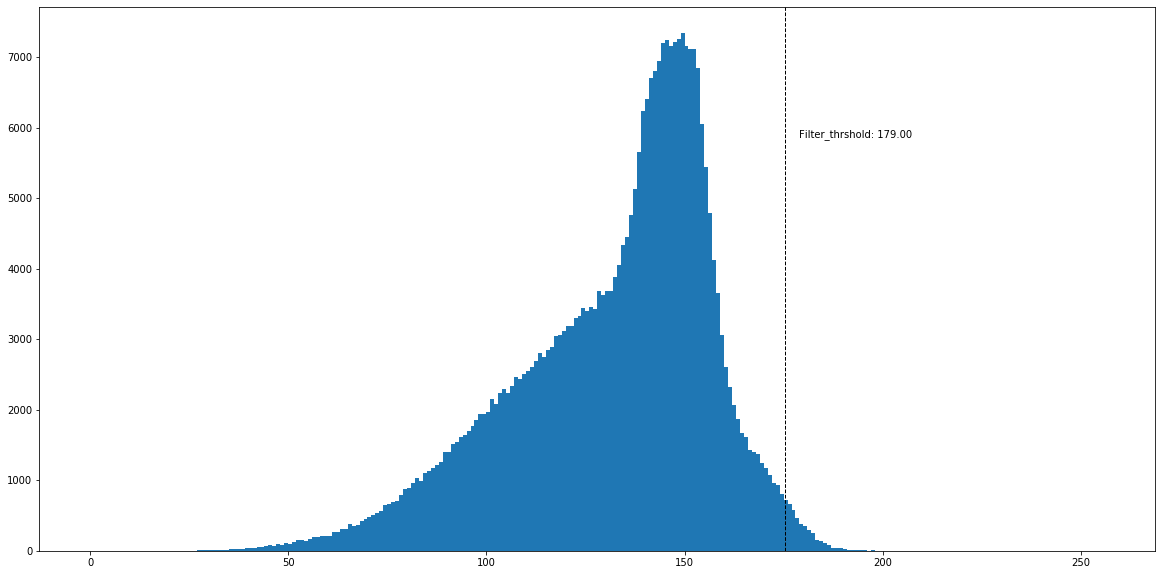

<Figure size 1440x720 with 0 Axes>

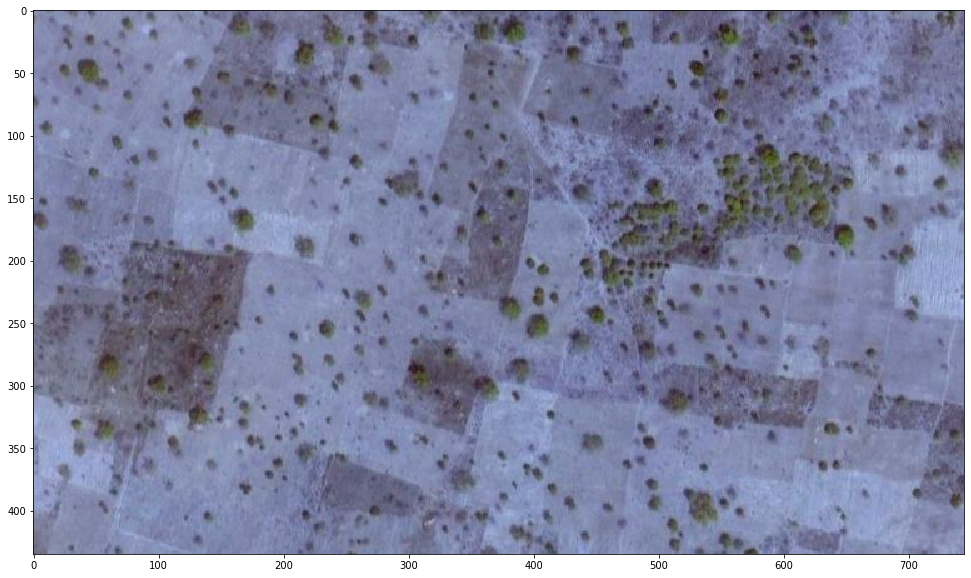

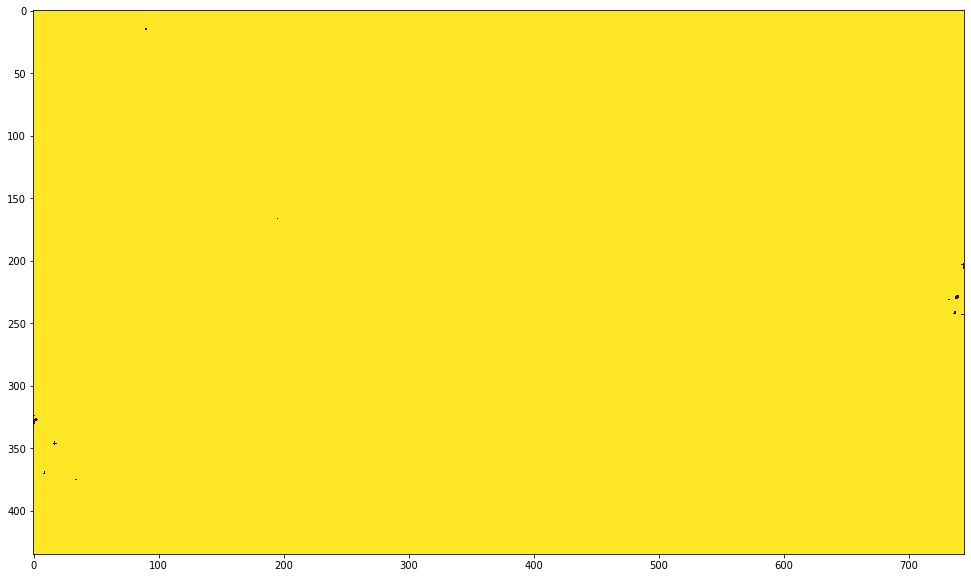

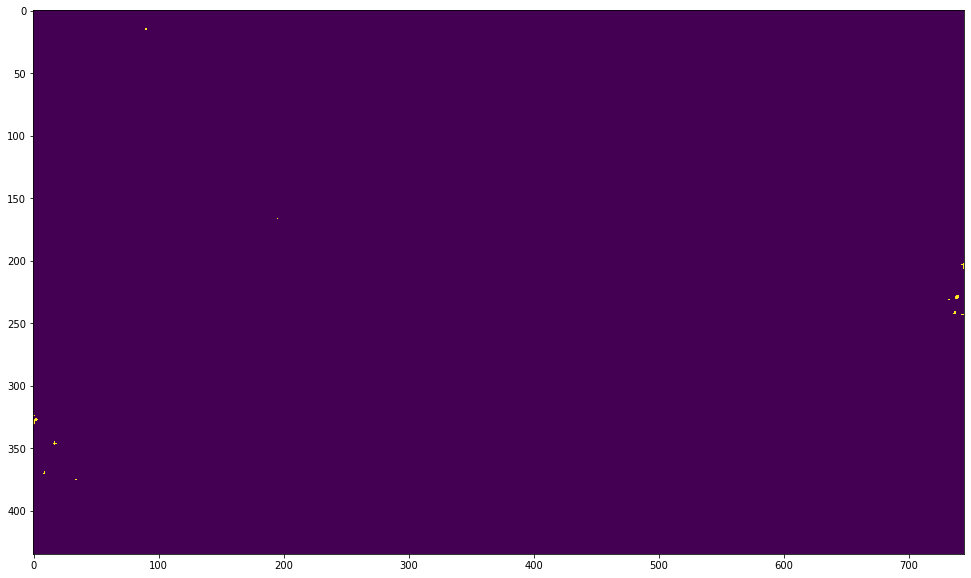

In [713]:
size_pixel_region=4

gr_image = read_image_gray(image)

pixels=gr_image.ravel()

f,ax = plt.subplots(figsize=(20,10))

n, b, patches =ax.hist(pixels,256,[0,256])


filter_thrs = np.quantile(pixels,quantile)

ax.axvline(filter_thrs*0.98, color='k', linestyle='dashed', linewidth=1)

bin_max = n.max()

ax.text(filter_thrs, bin_max*0.8, 'Filter_thrshold: {:.2f}'.format(filter_thrs))

plt.show()


s_image = segmentation_by_color(gr_image,filter_thrs)

plt.figure(figsize=(20,10))


sigma=1
blobs = gaus_filter(s_image,sigma)
a = polarisation(blobs)


plt.figure(figsize=(20,10))
plt.imshow(im)


plt.figure(figsize=(20,10))
plt.imshow(blobs)

plt.figure(figsize=(20,10))
plt.imshow(a)

Computing image nº 0: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

Number of HOUSES FOUND:  12


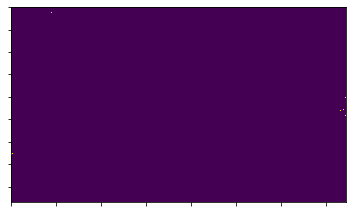

In [714]:
regs = []
begin = []
size_pixel_region=3
p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
n=max(int(p_1*160),1)
z=0
for chop in tqdm.tqdm([a[int(i*len(a)/n):int((i+1)*len(a)/n)] for i in range(n)],
                          desc = 'Computing image nº %1d'% ( z )):
    
    reg = locate_regions(chop) 

    regs.append(reg)
    begin.append(z*len(a)/n)
    z+=1

    f, ax = plt.subplots()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(chop)

    print("Number of HOUSES FOUND: % 3d"%(len(reg)))


Number of HOUSES FOUND WITH SIZE FILTER 3 pixels:   5


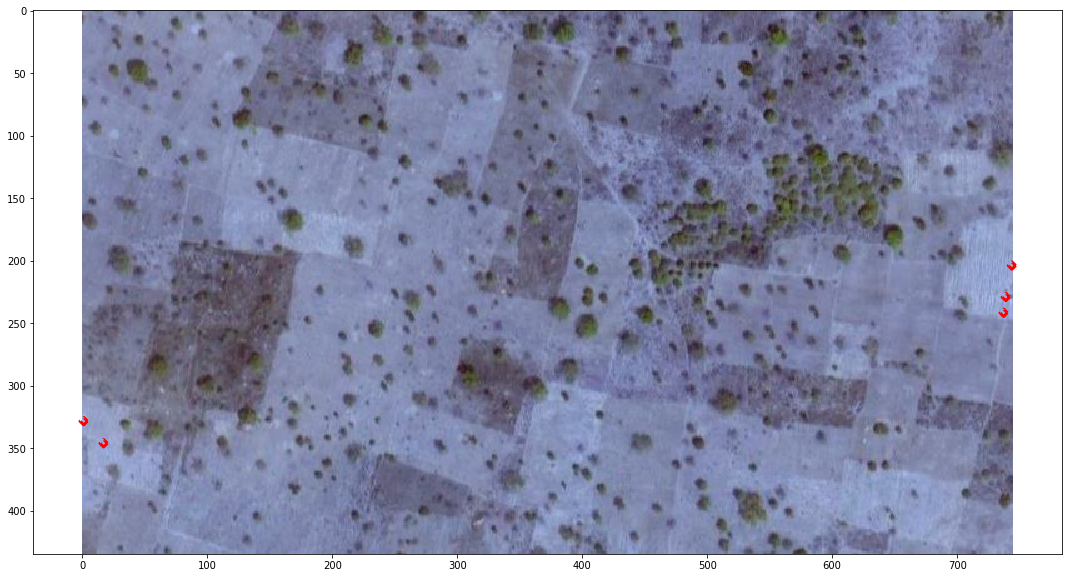

In [715]:
if len(regs)>0:
    long_crop_center = long_screen+abs(9.9597622-9.95976)
    lat_crop_center= lat_screen - abs(2.9468516-2.9467)
    center=(long_crop_center, lat_crop_center)
    
    coords=count_regions_and_plot_and_getcoord(regs,size_pixel_region,begin,im,center)

In [615]:
fig2

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px', width='800px'))

In [616]:
df_houses_alg=pd.DataFrame(coords,columns=['latitude','longitude'])

In [716]:
len(df_houses)

39

In [717]:
len(df_houses_alg)

35

# SAVE IN GSHEETs

## OPEN GOOGLE SHEETS

## AUTHENTIFICATION

In [91]:
def uploadFile(filename,filepath,folder_id,filetype,fileapp):    
    file_metadata = { 'name': filename,
                      'parents': [folder_id],
                      'mimeType': fileapp,
                    }  
                                                  
                             

    media = MediaFileUpload(filepath,
                            mimetype=filetype)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    
    #permission = drive_service.permissions().get(
        #fileId=file.get('id'), permissionId="-").execute()
    
    #permission['role'] = "owner"
    
    #return drive_service.permissions().update(
        #fileId=file.get('id'), permissionId="-", body=permission, transferOwnership=True).execute()

In [92]:
nom='df_houses_'+name
df_houses.to_csv(nom+'.csv')

In [93]:
drive_id_folder='1260i6QGMSd9aUdGHz9uez0ru523vCfq7'
uploadFile(nom + ".csv",
           nom + ".csv",
           drive_id_folder,"text/csv",'application/vnd.google-apps.spreadsheet')
os.remove(nom+'.csv')

# UPLOAD TO MYMAPS

click to see results

<a href="https://www.google.com/maps/d/edit?mid=1MtbdRCmYDSSSWThGlJ_ZYkJhvRczLeBl&ll=9.936057100985765%2C3.2051019633502165&z=17" target="_parent"><img src="https://lh4.googleusercontent.com/wFWTbQtnm83_tZYhu2w18mjQ8JGJ2OD_fE_dwFUHAQVm_O3tpQVnzB3vD_kwo0MXiapCG2SNQqRtx_uU4ydC-mBgRkiMfCPa_TZh79BOZMeY8Kh2zi4gYDRixc1SPmnNmQWuZDBN" alt="Open Maps"/></a>


## upload to firebase

In [354]:
#Convert info to dict and upload to firebase
houses = df_houses.to_dict('index')
houses_dict = [{k: v} for k, v in houses.items()] 
houses_l_dict = []
for i,house in enumerate(houses_dict):
    id_house=list(house.keys())[0]
    new_data={'coordinates':{
                    'longitude':house[id_house]['longitude'],
                    'latitude':house[id_house]['latitude']}
             }
    houses_l_dict.append(new_data)

    db.collection(u'houses').add(new_data)

# Distance to pompe

In [512]:
def distace_topump(x,coord_pump):
    x_dist = abs(coord_pump[0]-x['latitude'])*111111 
    y_dist = abs(coord_pump[1]-x['longitude'])*111111 
    distance = math.sqrt(x_dist**2+y_dist**2)
    
    return distance
    

In [542]:
coord_pump=(long,lat)
df_houses['distance']=df_houses.apply(lambda x: distace_topump(x,coord_pump),axis=1)

In [543]:
#4km/h speed walk, how many minutes in average people do to the source
dist_in_min=df_houses['distance'].mean()*60/4000
print('Mean average time to pump %3.2f min'%(dist_in_min))

Mean average time to pump 7.29 min
